In [1]:
!pip install pennylane
!python -m pip install pennylane-sf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!/usr/bin/env python3
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# import nlopt
import strawberryfields as sf
from strawberryfields import ops

# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Other tools
import time
import os
import copy

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.utils import shuffle
from sklearn import datasets

env: OMP_NUM_THREADS=1


In [3]:
steps = 1060
batch_size = 2
qmodes = 4
params_num = 7
circuit_weights = []
load_params = False

In [4]:
def visualize_dataset(trainX, trainY) -> None:
    fig, axs = plt.subplots(nrows=4, ncols=4)

    colors = ['red', 'blue', 'green']
    test_colors = ['purple', 'black', 'yellow']

    for i in range(4):
        for j in range(4):
            for k in np.unique(trainY, axis=0):
                axs[i % 4, j % 4].plot(trainX[trainY == k, i],
                                       trainX[trainY == k, j],
                                       'o', label='class {}'.format(k), color=colors[k]
                                       )

                axs[i % 4, j % 4].legend(fontsize=5,
                                         ncol=1,
                                         facecolor='oldlace',
                                         edgecolor='r'
                                         )

                # axs[i % 4, j % 4].set_xlim(-1, 10)
                # axs[i % 4, j % 4].set_ylim(-1, 10)

    fig.set_size_inches(10., 6.5)
    plt.show()

In [5]:
def create_dataset():

    iris = datasets.load_iris()
    x = iris.data
    Y = iris.target
    
    visualize_dataset(x, Y)
    
    y = []
    for i in range(len(Y)):
        if Y[i] == 0:
            y.append([1., 0., 0.])
        elif Y[i] == 1:
            y.append([0., 1., 0.])
        elif Y[i] == 2:
            y.append([0., 0., 1.])

    x, y = shuffle(x, np.array(y), random_state=1917)
#     x, y = shuffle(x, Y, random_state=7)
    
    sep = round(len(x) * 0.1)
    
    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    return train_x, train_y, test_x, test_y

#Model

In [6]:
shots = 1000  # кол-во измерений для набора статистики
dev = qml.device("strawberryfields.fock", wires=4, cutoff_dim=5, shots=shots)

In [7]:
params_num = 7

def layer(params, sample):
    for j in range(4):
        qml.Squeezing(1.5, sample[j], wires=j)
    
    qml.Beamsplitter(np.pi / 4, 0.0, wires=[0, 1])
    qml.Beamsplitter(np.pi / 4, 0.0, wires=[2, 3])
    qml.Rotation(params[0], wires=0)
    qml.Rotation(params[1], wires=1)
    qml.Rotation(params[2], wires=2)
    qml.Beamsplitter(np.pi / 4, 0.0, wires=[1, 2])
    qml.Rotation(params[3], wires=1)
    qml.Displacement(params[4], 0.0, wires=0)
    qml.Displacement(params[5], 0.0, wires=1)
    qml.Displacement(params[6], 0.0, wires=2)


@qml.qnode(dev)
def circuit(params, sample, fock_prob):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(fock_prob, wires=[0, 1, 2, 3]))


def classifier(params, x):
    o0 = circuit(params, x, np.array([2, 0, 0, 0], requires_grad=False))
    o1 = circuit(params, x, np.array([0, 2, 0, 0], requires_grad=False))
    o2 = circuit(params, x, np.array([0, 0, 2, 0], requires_grad=False))
    summ = o1 + o2 + o0 + 1e-8
    p0 = o0 / summ
    p1 = o1 / summ
    p2 = o2 / summ
    return np.array([p0, p1, p2], requires_grad = True)

$L = - Σy_i log(p_i) / N$

In [8]:
[1.0, 0.0, 0.0] == [1.0, 0.0, 0.0] 

True

In [9]:
def log_loss(labels, predictions):
    loss = 0
    for i in range(len(labels)):
        loss = loss + np.sum(labels * np.log(np.abs(predictions))) / len(labels)

    return loss


def accuracy(labels, predictions):
    acc = 0
    # pred = np.round(predictions, requires_grad=False)
    for l, p in zip(np.argmax(labels, axis=1), np.argmax(np.abs(predictions), axis=1)):
        # print(l, p)
        if l == p:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

In [10]:
def cost(var, data_input, labels):
    predictions = np.array([classifier(var, x) for x in data_input], requires_grad=True)
    # print(predictions)
    squared_loss = log_loss(labels, predictions)
    
    return np.absolute(squared_loss)

# Train

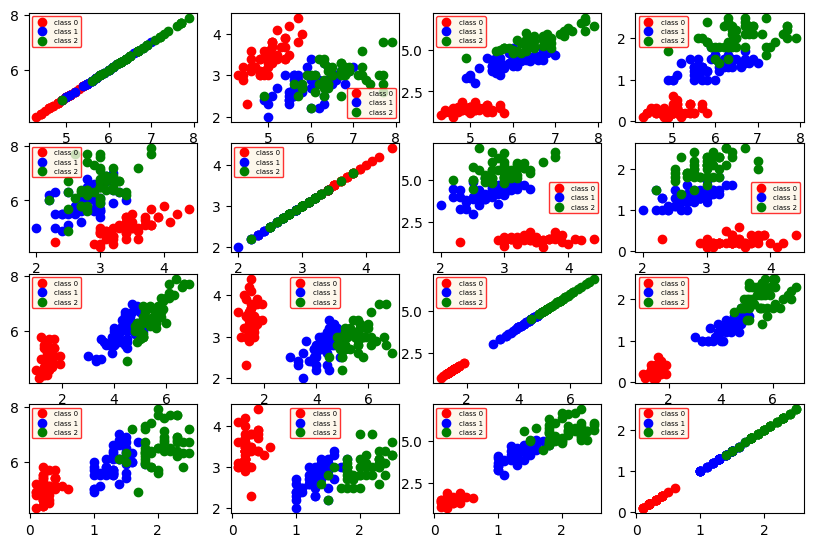

In [11]:
train_x, train_y, test_x, test_y = create_dataset()

In [12]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

optimizer = qml.optimize.AdamOptimizer(stepsize=0.025)
# optimizer = qml.GradientDescentOptimizer(stepsize=0.025)
steps = 40
var = np.array([0.5]*params_num, requires_grad=True)
for step in range(steps):
    print(f'trainable params: {var}')

    var = optimizer.step(lambda v: cost(v, train_x, train_y), var)

    predictions = np.array([classifier(var, x) for x in test_x], requires_grad=False)
    val_accuracy = accuracy(test_y, predictions)
    val_loss = log_loss(test_y, predictions)

    predictions = np.array([classifier(var, x) for x in train_x], requires_grad=False)
    train_accuracy = accuracy(train_y, predictions)
    train_loss = log_loss(train_y, predictions)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.7f} | Train accuracy: {train_accuracy} | Val Loss: {val_loss:0.7f} | Val_accuracy: {val_accuracy} ")

trainable params: [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Iter:     1 | Train Loss: -209.1288139 | Train accuracy: 0.17037037037037037 | Val Loss: -21.8155225 | Val_accuracy: 0.26666666666666666 
trainable params: [0.475 0.475 0.475 0.475 0.475 0.475 0.475]
Iter:     2 | Train Loss: -199.1320146 | Train accuracy: 0.15555555555555556 | Val Loss: -20.4063339 | Val_accuracy: 0.2 
trainable params: [0.46782209 0.46351128 0.48076776 0.46316072 0.49114545 0.46971515
 0.46427111]
Iter:     3 | Train Loss: -214.3920705 | Train accuracy: 0.2074074074074074 | Val Loss: -23.5223966 | Val_accuracy: 0.2 
trainable params: [0.45988705 0.4513675  0.48099767 0.45188161 0.49781725 0.45826402
 0.45788371]
Iter:     4 | Train Loss: -191.6716963 | Train accuracy: 0.26666666666666666 | Val Loss: -20.5954528 | Val_accuracy: 0.13333333333333333 
trainable params: [0.45239896 0.43847759 0.47819517 0.43695903 0.50027607 0.4482728
 0.45043872]
Iter:     5 | Train Loss: -215.5924168 | Train accuracy: 0.17777777777777778 |

KeyboardInterrupt: ignored